# Assignment - Data Science

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from IPython.display import Image  
from six import StringIO
from imblearn.over_sampling import SMOTE

### Use Random Seed = 42

In [2]:
RANDOM_SEED = 42

## 1. Load the data

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sree1ekha/employee-data")

print("Path to dataset files:", path)

/Users/satyamvats/Documents/ioco/poc/python/data-science-practice/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 161k/161k [00:00<00:00, 200kB/s]

Extracting files...
Path to dataset files: /Users/satyamvats/.cache/kagglehub/datasets/sree1ekha/employee-data/versions/1


In [4]:
# Load datasets
train_df = pd.read_csv(f'{path}/Train_Dataset.csv')
test_df = pd.read_csv(f'{path}/Test_Dataset.csv')

# Concatenate the datasets
merged_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# Save the merged dataset to a new CSV
merged_df.to_csv('Complete_Dataset.csv', index=False)

print("Datasets merged and saved as Complete_Dataset.csv")

Datasets merged and saved as Complete_Dataset.csv


In [6]:
data = pd.read_csv(f'./Complete_Dataset.csv')

## 2. Perform the exploratory data analysis

### First 10 rows of the data

In [7]:
print("First 10 rows of the data:")
print(data.head(10))

First 10 rows of the data:
   EmployeeID  Attrition   Age TravelProfile Department  HomeToWork  \
0   5110001.0        0.0  35.0        Rarely  Analytics         5.0   
1   5110002.0        1.0  32.0           Yes      Sales         5.0   
2   5110003.0        0.0  31.0        Rarely  Analytics         5.0   
3   5110004.0        0.0  34.0           Yes      Sales        10.0   
4   5110005.0        0.0  37.0            No  Analytics        27.0   
5   5110006.0        1.0  34.0           Yes  Marketing        24.0   
6   5110007.0        0.0  35.0           Yes      Sales         1.0   
7   5110008.0        1.0  26.0        Rarely      Sales         8.0   
8   5110009.0        0.0  45.0           Yes  Analytics         5.0   
9   5110010.0        1.0  24.0        Rarely      Sales         4.0   

      EducationField  Gender  HourlnWeek  Involvement  ...  JobSatisfaction  \
0                 CA    Male        69.0          1.0  ...              1.0   
1         Statistics  Female     

### 5-point summary

In [8]:
print("\n5-point summary:")
print(data.describe())


5-point summary:
         EmployeeID    Attrition          Age   HomeToWork   HourlnWeek  \
count  7.810000e+03  5180.000000  7352.000000  7429.000000  7387.000000   
mean   5.448909e+06     0.278958    37.215860    11.215507    57.940436   
std    4.720273e+05     0.448530     9.286258     8.590705    13.076675   
min    5.110001e+06     0.000000    18.000000     1.000000    10.000000   
25%    5.111953e+06     0.000000    30.000000     5.000000    49.000000   
50%    5.113906e+06     0.000000    36.000000     9.000000    59.000000   
75%    6.110678e+06     1.000000    43.000000    16.000000    67.000000   
max    6.112630e+06     1.000000    61.000000   123.000000   110.000000   

       Involvement  WorkLifeBalance  JobSatisfaction        ESOPs  \
count  7810.000000      7810.000000      7810.000000  7810.000000   
mean      3.230986         3.031754         3.134699     0.495391   
std       0.876355         1.412770         1.341073     0.500011   
min       1.000000         1.0

### Information about the column (data types)

In [9]:
print("\nInformation about the columns:")
print(data.info())


Information about the columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10440 entries, 0 to 10439
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   EmployeeID          7810 non-null   float64
 1   Attrition           5180 non-null   float64
 2   Age                 7352 non-null   float64
 3   TravelProfile       7810 non-null   object 
 4   Department          7628 non-null   object 
 5   HomeToWork          7429 non-null   float64
 6   EducationField      7810 non-null   object 
 7   Gender              7734 non-null   object 
 8   HourlnWeek          7387 non-null   float64
 9   Involvement         7810 non-null   float64
 10  WorkLifeBalance     7810 non-null   float64
 11  Designation         7742 non-null   object 
 12  JobSatisfaction     7810 non-null   float64
 13  ESOPs               7810 non-null   float64
 14  NumCompaniesWorked  7810 non-null   float64
 15  OverTime            7

### Number of outliers (using IQR method)

Number of outliers in the dataset: 2648


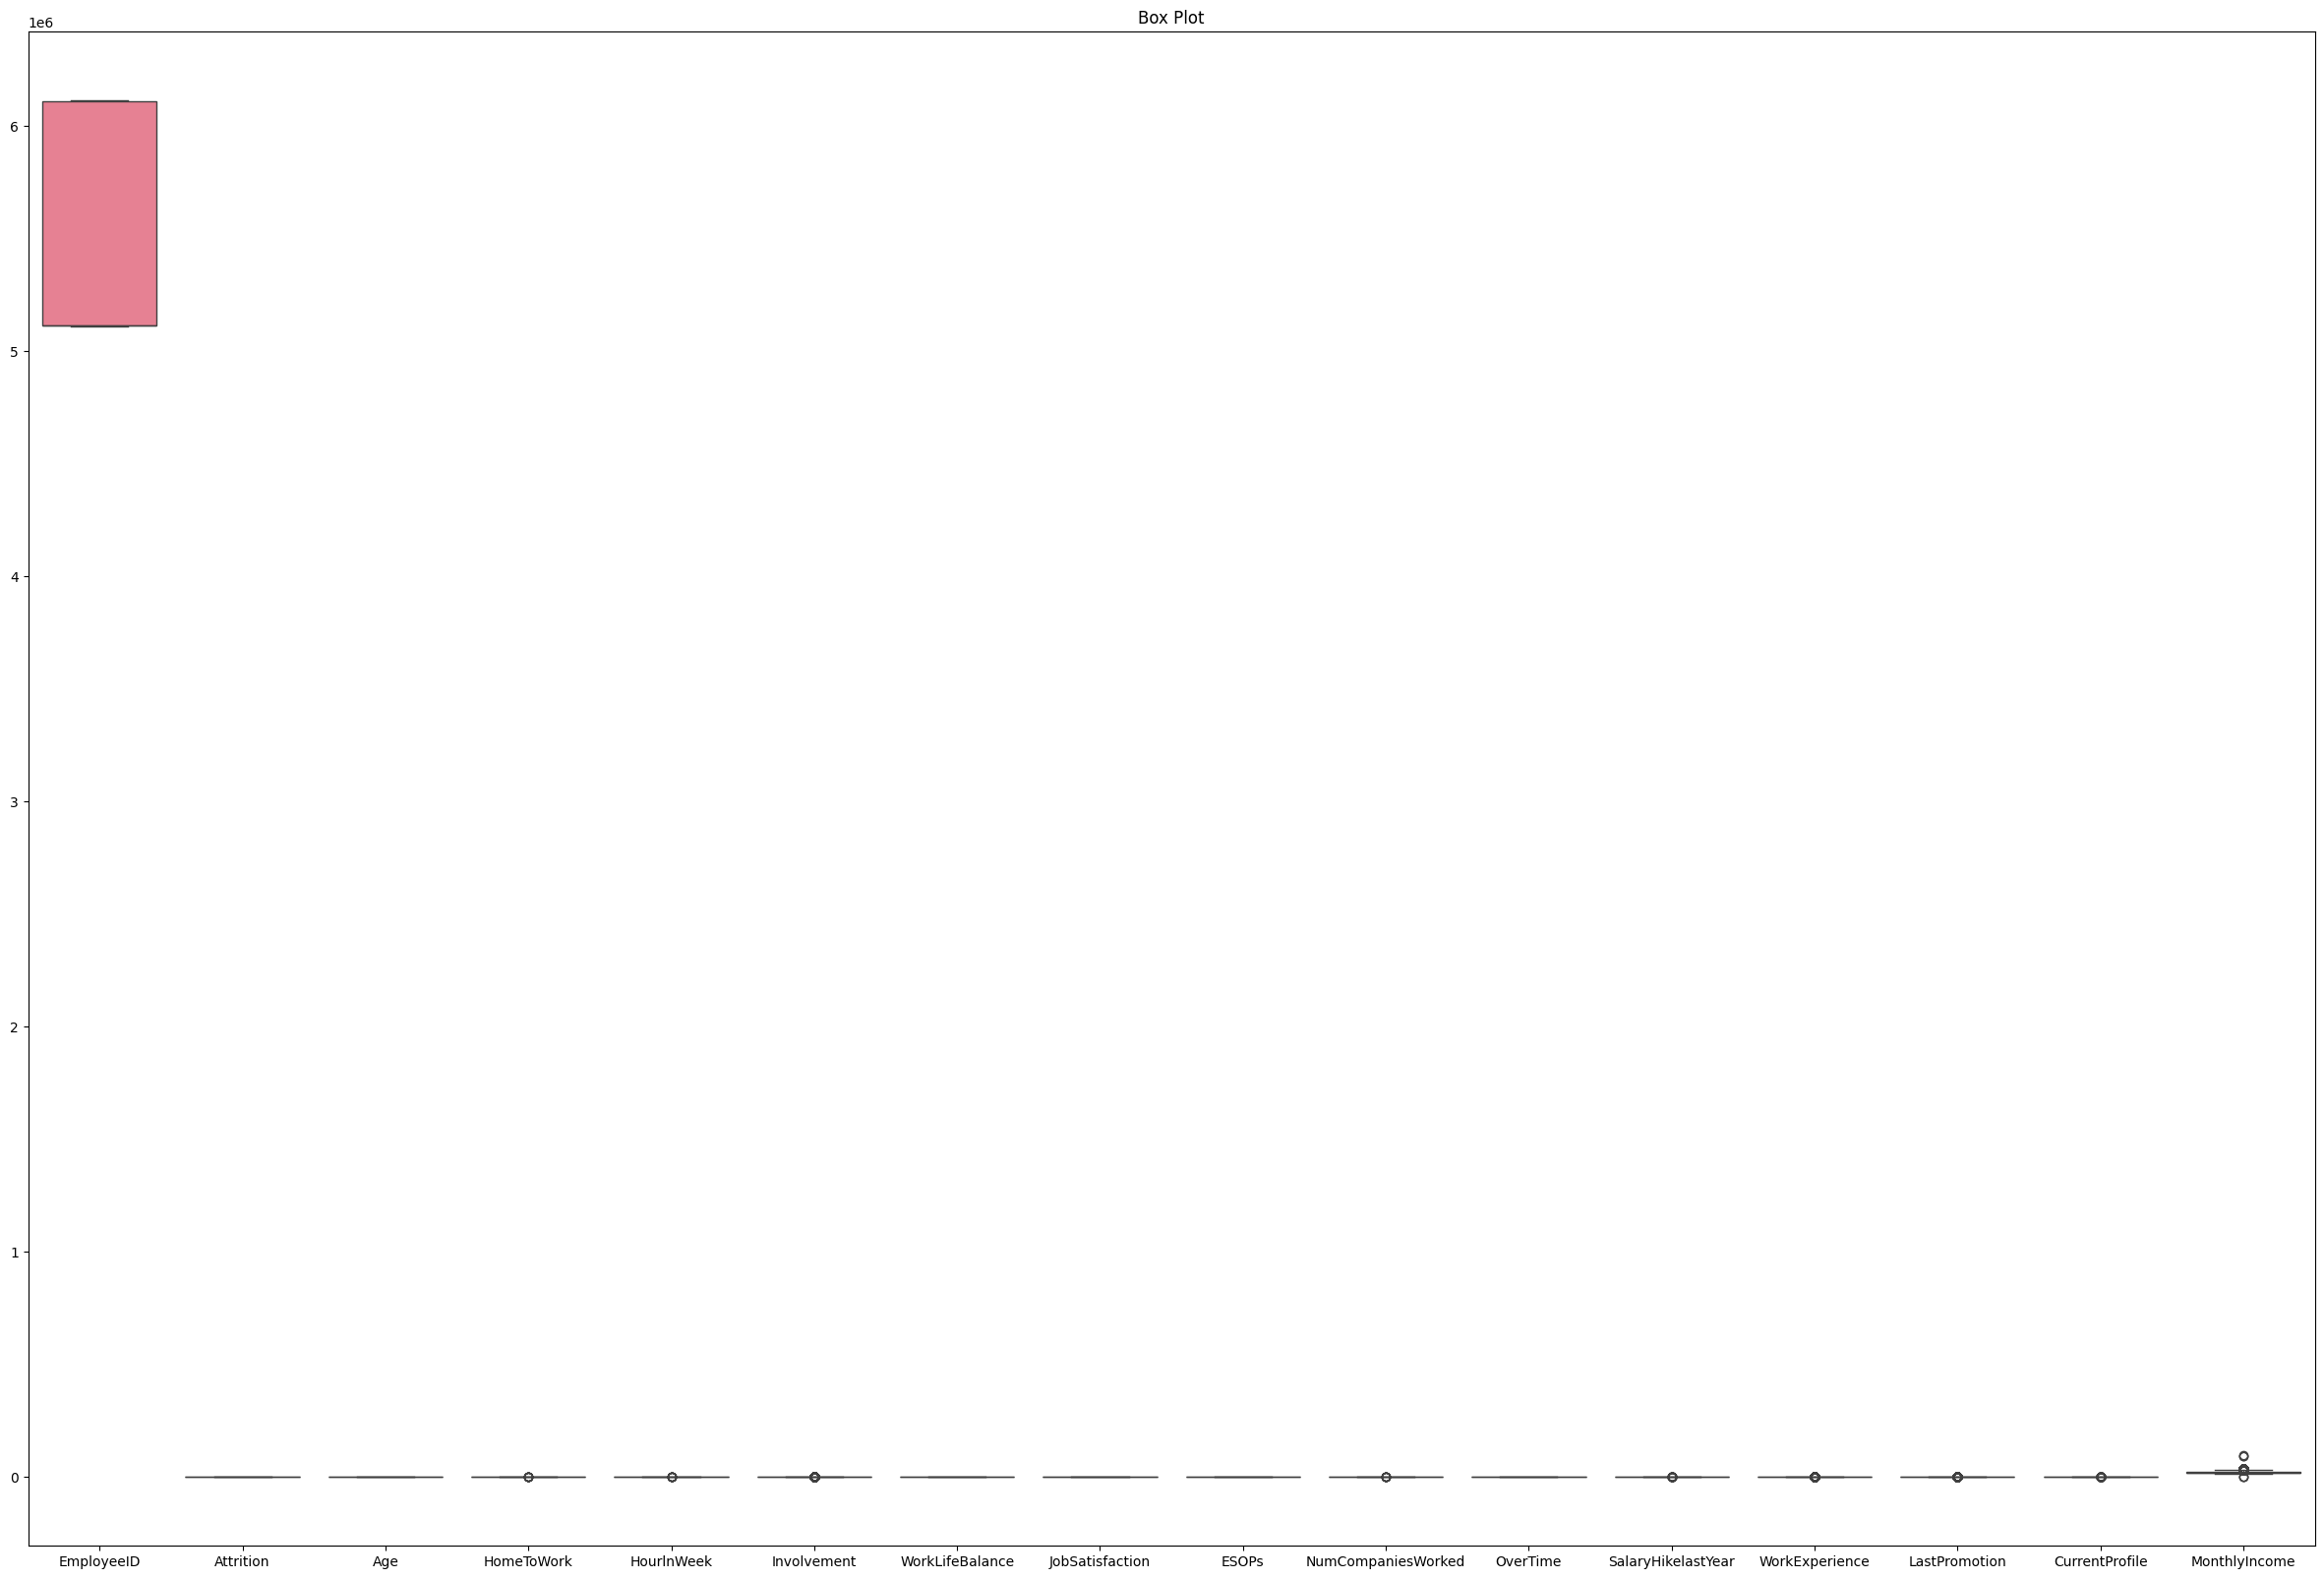

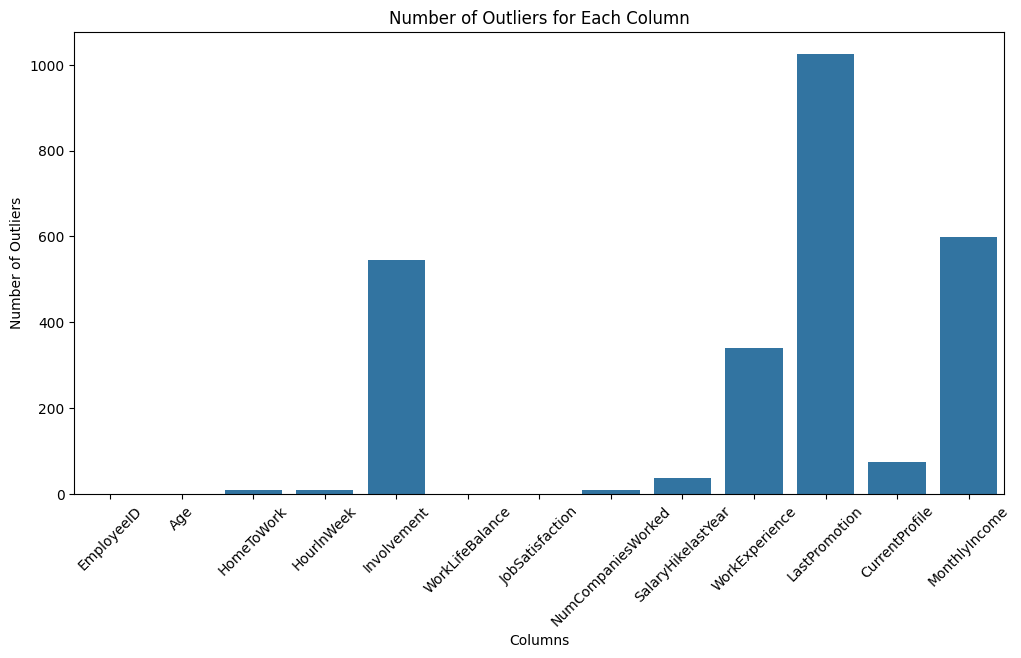

In [10]:
# Identify numeric columns, excluding binary columns
# When dealing with binary columns that have values 0 and 1, the typical methods for identifying outliers 
# (such as the IQR method) don't apply effectively. In these cases, outliers are generally not considered 
# because all values are valid representations of the data. Instead, we should focus on the numeric columns 
# where outliers can have a significant impact.
numeric_cols = [col for col in data.select_dtypes(include=[np.number]).columns if data[col].nunique() > 2]

# Calculate IQR for numerical columns
Q1 = data[numeric_cols].quantile(0.25)
Q3 = data[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Determine outliers
outliers_mask = ((data[numeric_cols] < (Q1 - 1.5 * IQR)) | (data[numeric_cols] > (Q3 + 1.5 * IQR)))

# Count number of outliers for each column
outliers_count = outliers_mask.sum()

# Calculate the number of outliers
num_outliers = outliers_mask.sum().sum()

print(f"Number of outliers in the dataset: {num_outliers}")

# Optional: Display the outliers
outliers = data[outliers_mask.any(axis=1)]

plt.figure(figsize=(30, 20))
sns.boxplot(data=data)
plt.title("Box Plot")
plt.show()

# Plot the number of outliers for each column
plt.figure(figsize=(12, 6))
sns.barplot(x=outliers_count.index, y=outliers_count.values)
plt.xticks(rotation=45)
plt.xlabel('Columns')
plt.ylabel('Number of Outliers')
plt.title('Number of Outliers for Each Column')
plt.show()

### Missing value


Number of missing values: 63348


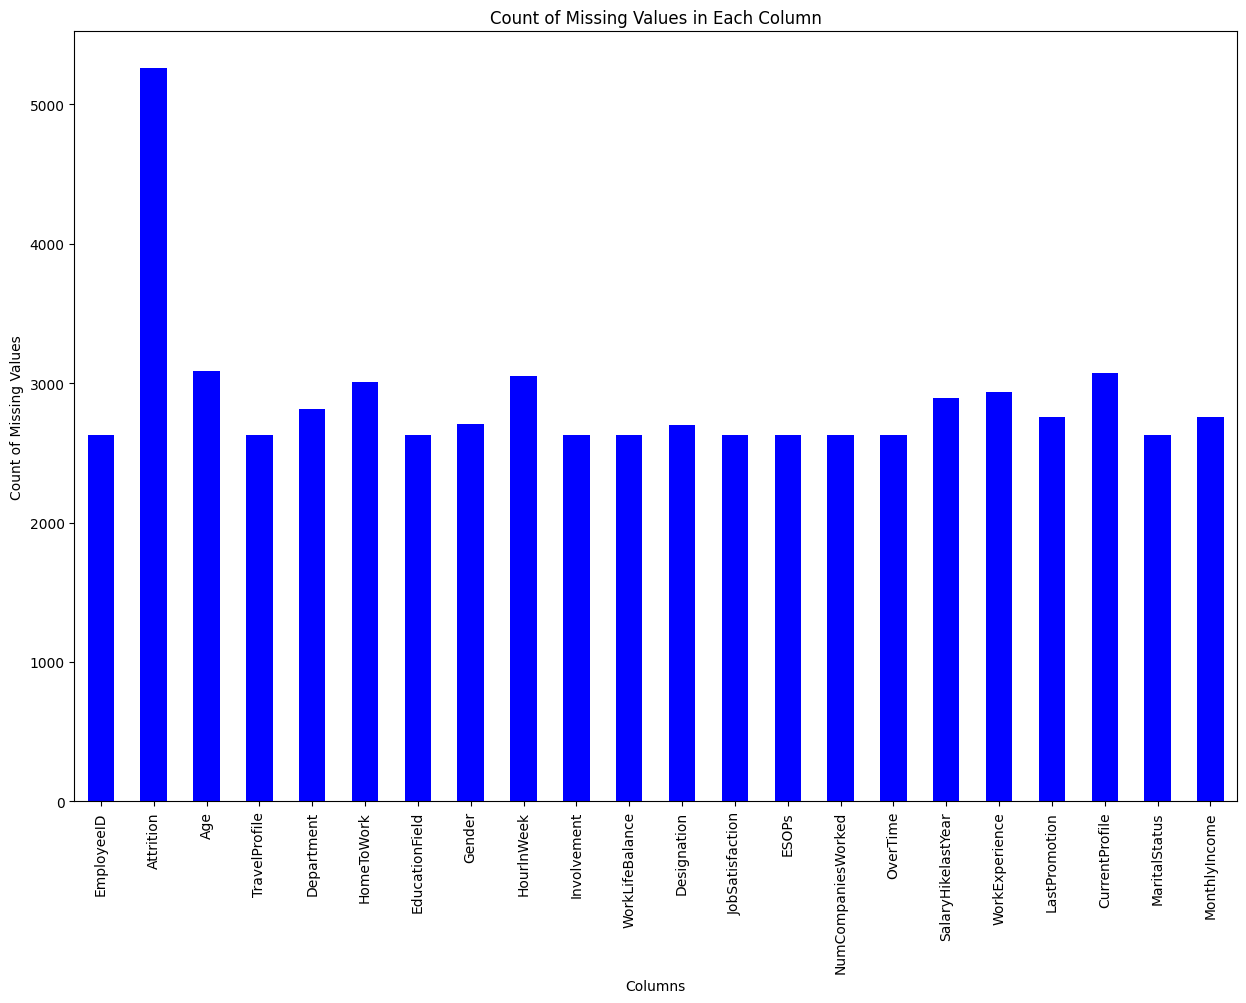

In [11]:
missing_values = data.isnull().sum().sum()
print(f"\nNumber of missing values: {missing_values}")

# Count of missing values in each column
missing_values_count = data.isnull().sum()
missing_values_count = missing_values_count[missing_values_count > 0]
plt.figure(figsize=(15, 10))
missing_values_count.plot(kind='bar', color='blue')
plt.title("Count of Missing Values in Each Column")
plt.xlabel("Columns")
plt.ylabel("Count of Missing Values")
plt.show()

### Correlation between variables


Correlation matrix:
                    EmployeeID  Attrition       Age  HomeToWork  HourlnWeek  \
EmployeeID            1.000000  -0.023067  0.016196    0.017612   -0.004195   
Attrition            -0.023067   1.000000 -0.185756    0.093010    0.019705   
Age                   0.016196  -0.185756  1.000000    0.004700    0.002802   
HomeToWork            0.017612   0.093010  0.004700    1.000000    0.057822   
HourlnWeek           -0.004195   0.019705  0.002802    0.057822    1.000000   
Involvement           0.006952   0.144332 -0.027461   -0.008605   -0.031412   
WorkLifeBalance       0.018890   0.013608  0.005668    0.001812    0.012544   
JobSatisfaction      -0.010162   0.126745 -0.007668    0.006593    0.051688   
ESOPs                 0.013636   0.012200 -0.004456    0.009853    0.003442   
NumCompaniesWorked    0.011784   0.049829  0.292483   -0.011425    0.027937   
OverTime              0.016731   0.281113  0.013692    0.042643    0.038306   
SalaryHikelastYear   -0.001577 

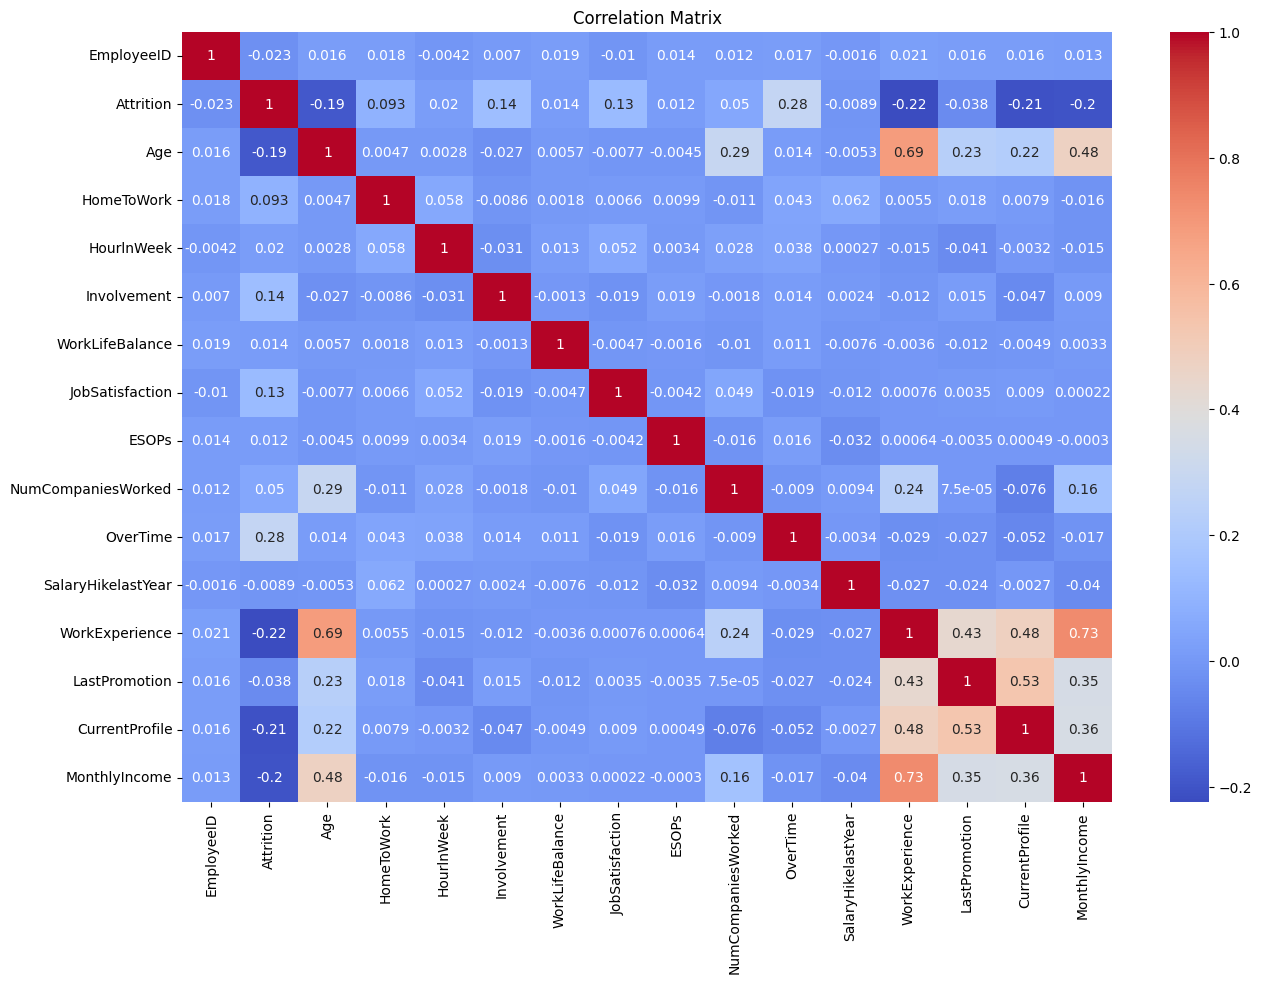

In [12]:
print("\nCorrelation matrix:")
# Convert float columns to numeric
numeric_data = data.select_dtypes(include=[np.float64]).apply(pd.to_numeric)

print(numeric_data.corr())

plt.figure(figsize=(15, 10))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

### Distribution of the data


Distribution of the data:
          EmployeeID    Attrition          Age TravelProfile Department  \
count   7.810000e+03  5180.000000  7352.000000          7810       7628   
unique           NaN          NaN          NaN             3          3   
top              NaN          NaN          NaN        Rarely  Analytics   
freq             NaN          NaN          NaN          5489       4894   
mean    5.448909e+06     0.278958    37.215860           NaN        NaN   
std     4.720273e+05     0.448530     9.286258           NaN        NaN   
min     5.110001e+06     0.000000    18.000000           NaN        NaN   
25%     5.111953e+06     0.000000    30.000000           NaN        NaN   
50%     5.113906e+06     0.000000    36.000000           NaN        NaN   
75%     6.110678e+06     1.000000    43.000000           NaN        NaN   
max     6.112630e+06     1.000000    61.000000           NaN        NaN   

         HomeToWork EducationField Gender   HourlnWeek  Involvement  ...

<Figure size 1500x1000 with 0 Axes>

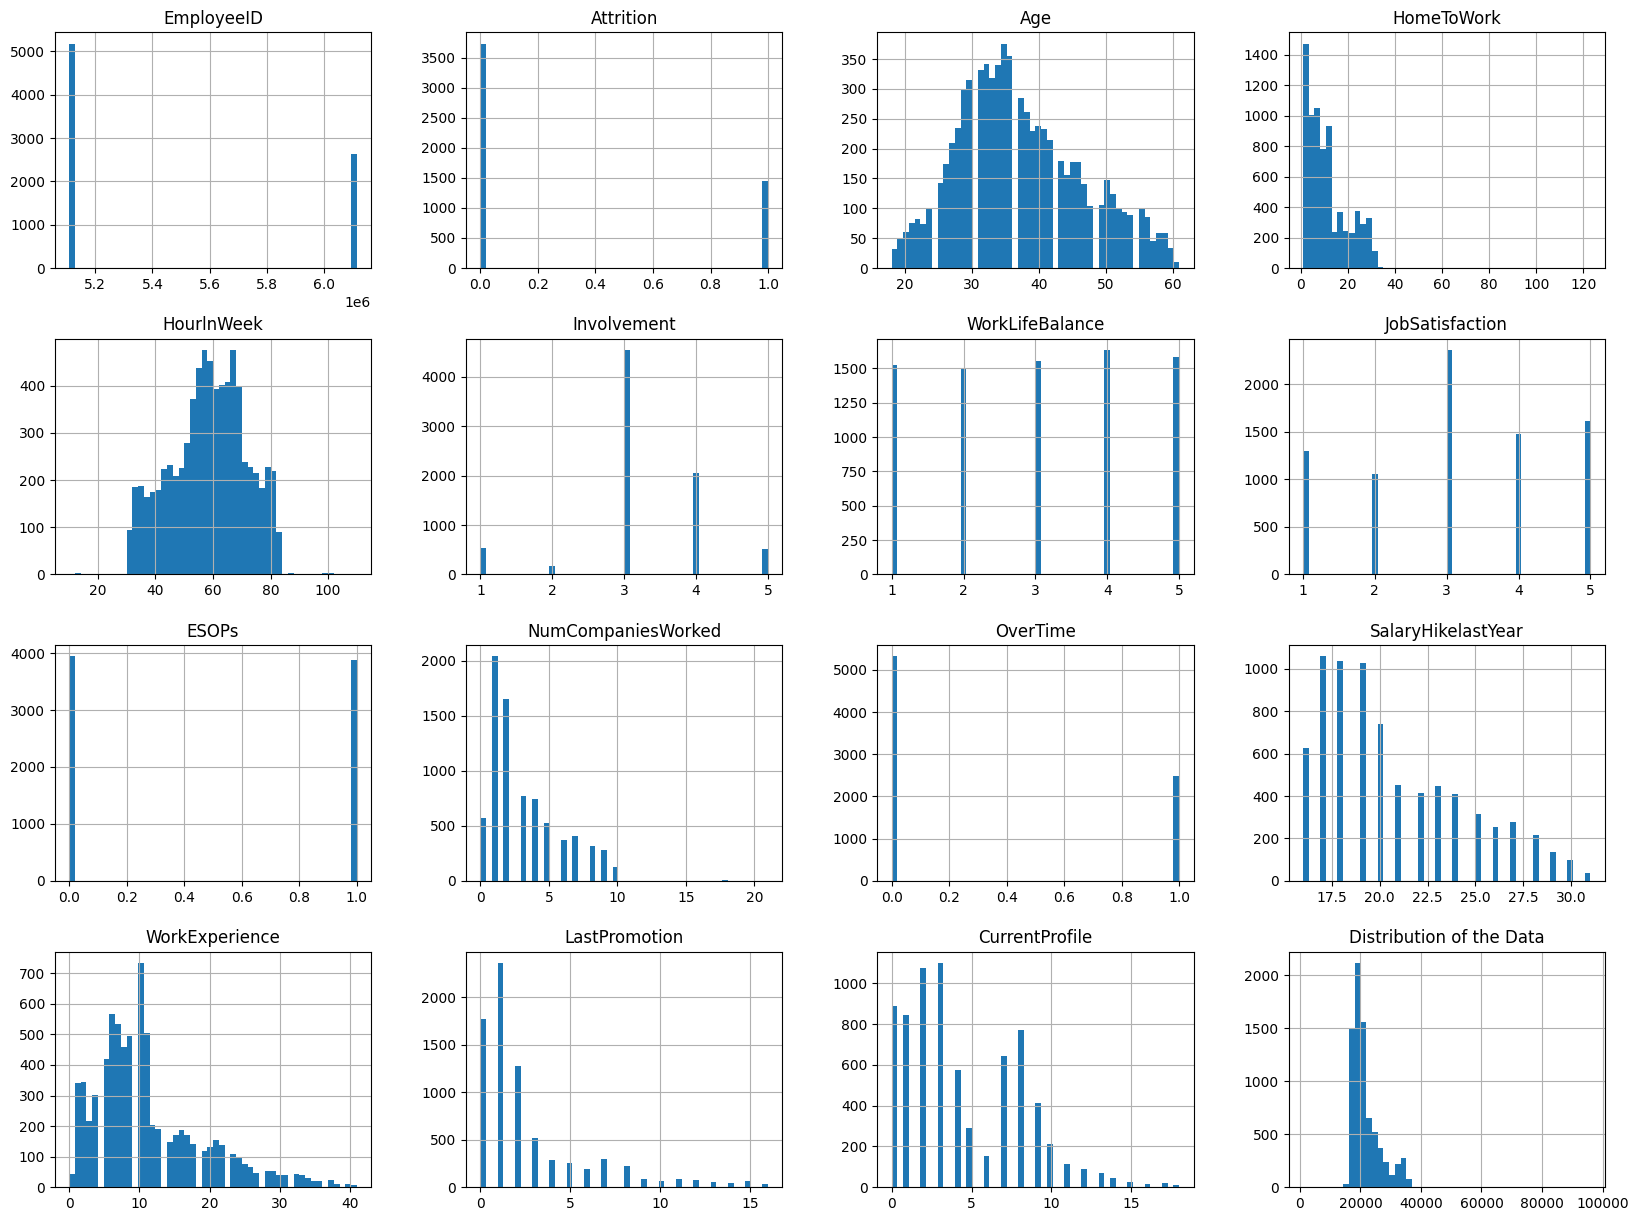

In [13]:
print("\nDistribution of the data:")
print(data.describe(include='all'))

# Show the distribution of the data
plt.figure(figsize=(15, 10))
data.hist(bins=50, figsize=(20, 15))
plt.title("Distribution of the Data")
plt.show()

### Other Charts and graphs

In [14]:
print(data[numeric_cols].columns)

Index(['EmployeeID', 'Age', 'HomeToWork', 'HourlnWeek', 'Involvement',
       'WorkLifeBalance', 'JobSatisfaction', 'NumCompaniesWorked',
       'SalaryHikelastYear', 'WorkExperience', 'LastPromotion',
       'CurrentProfile', 'MonthlyIncome'],
      dtype='object')


<Figure size 2000x1500 with 0 Axes>

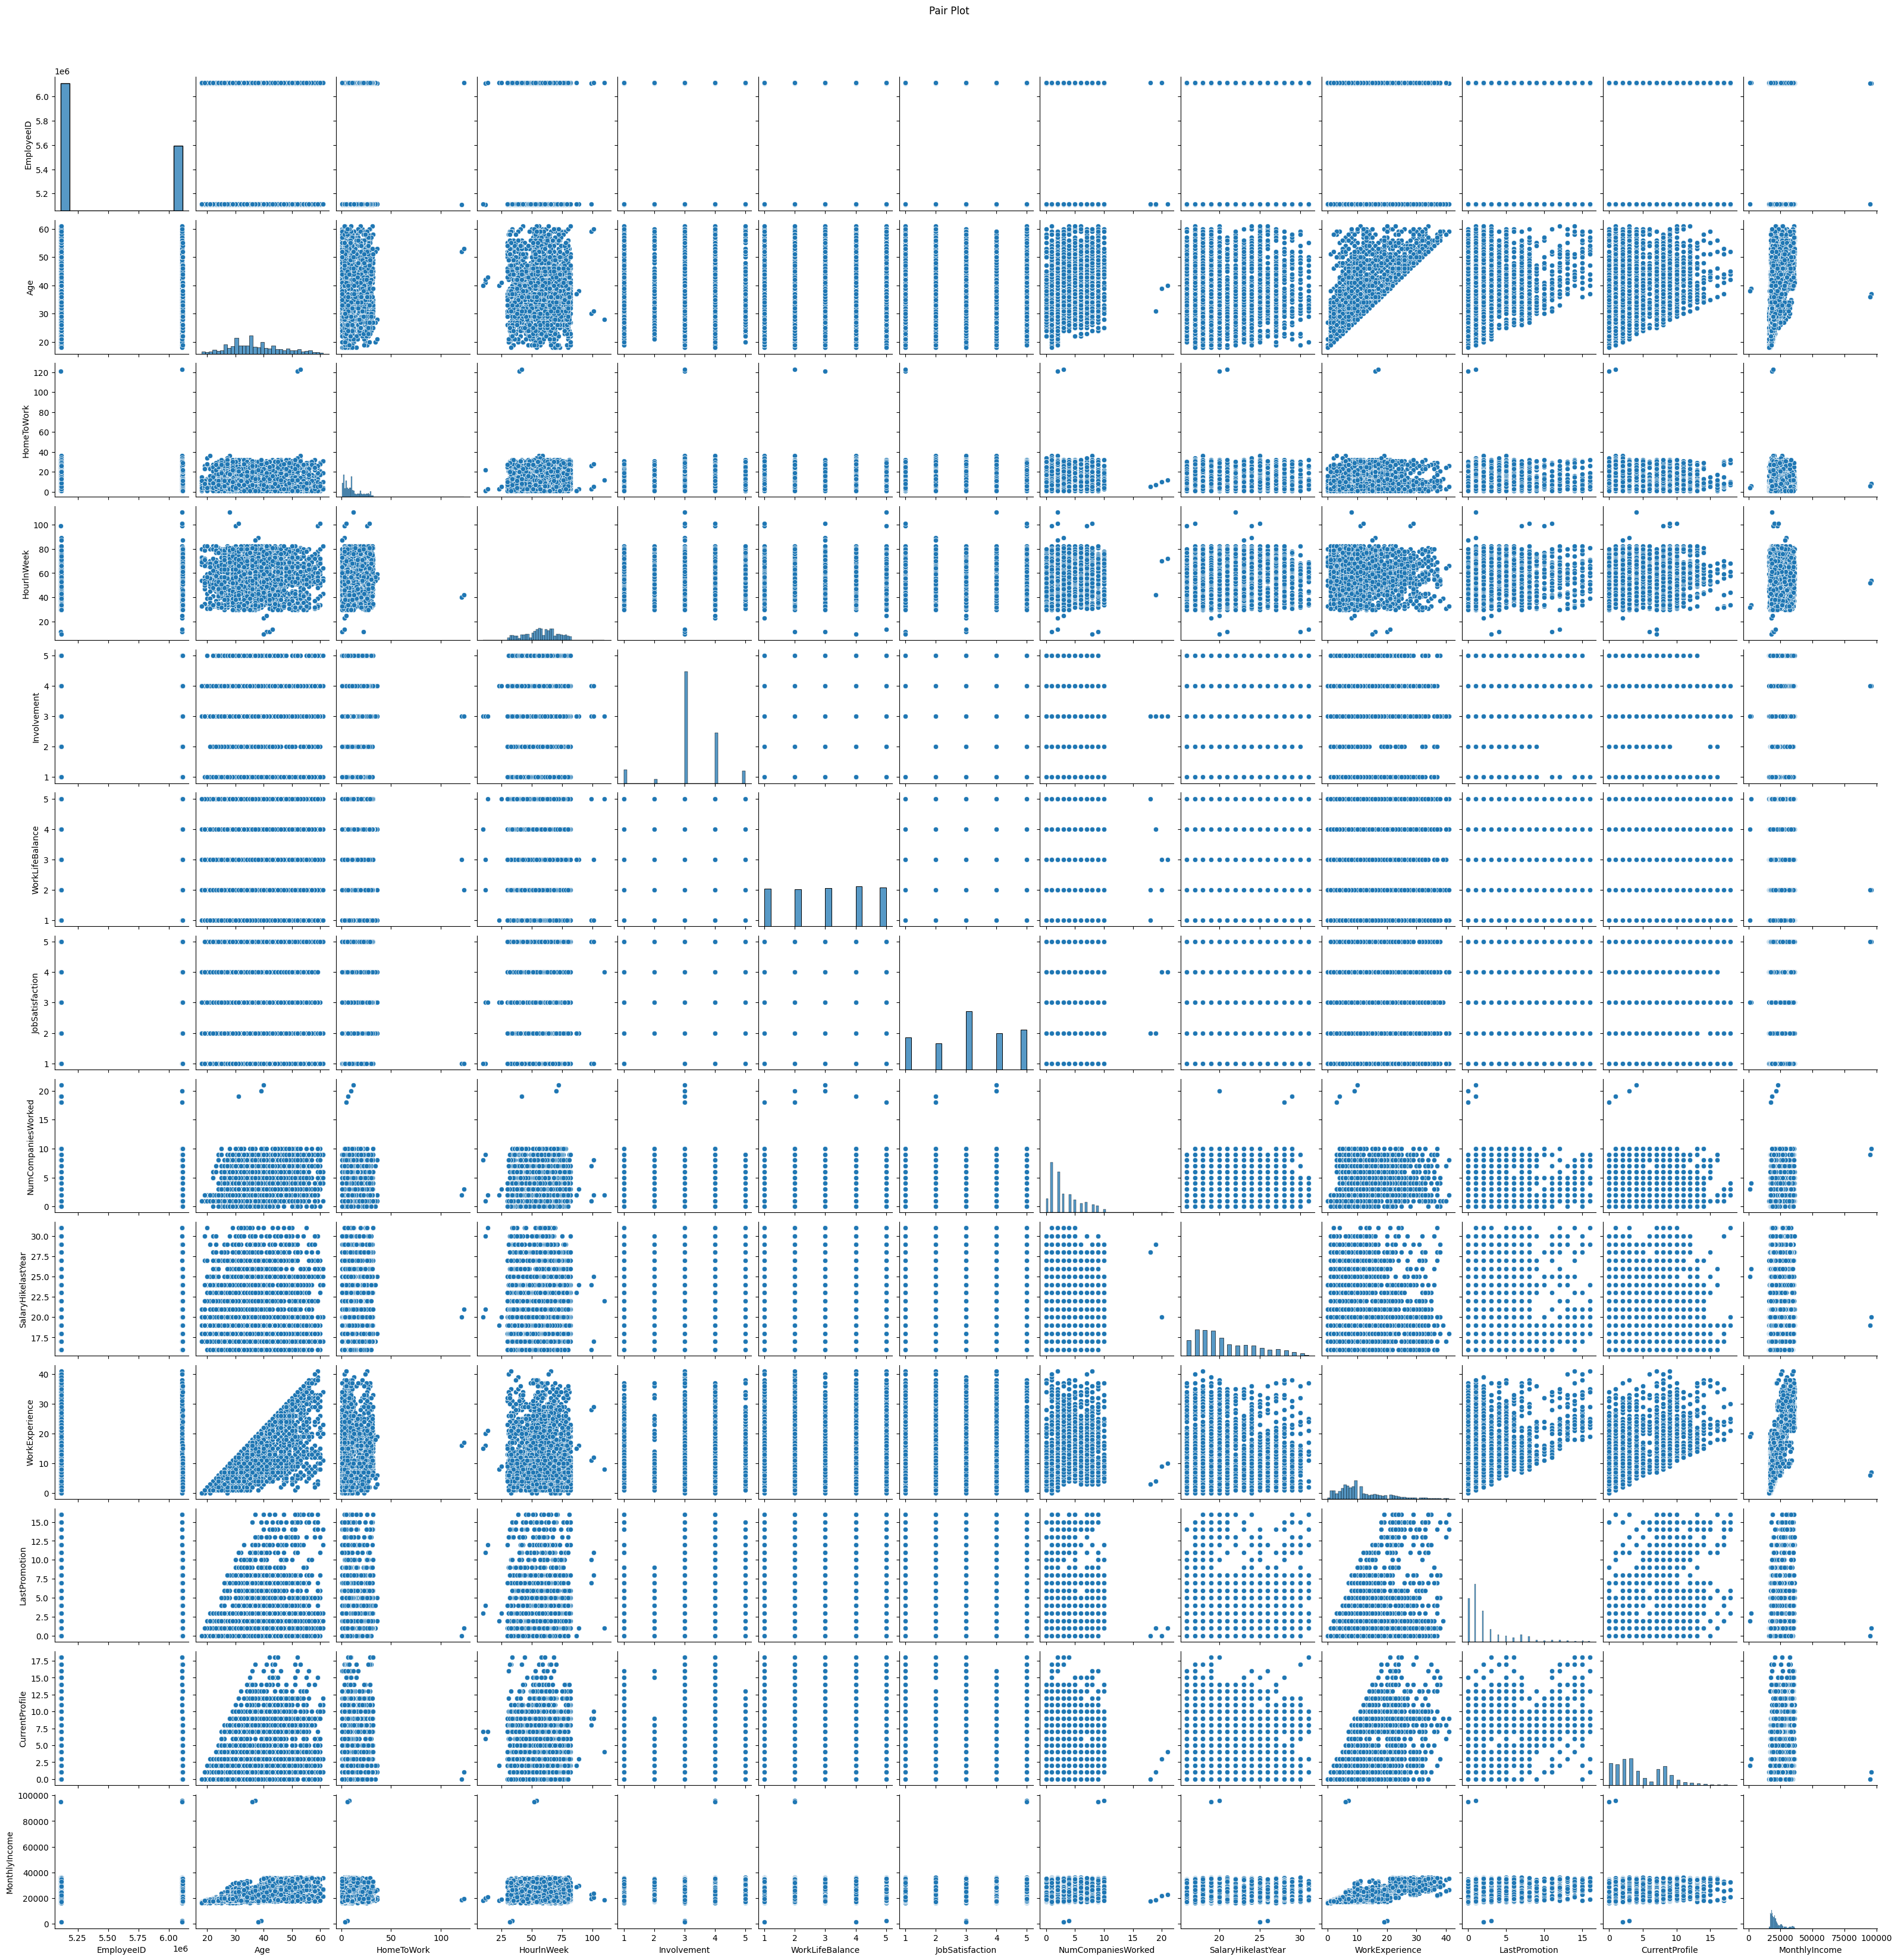

In [15]:
# Show the pair plot of the data
plt.figure(figsize=(20, 15))
sns.pairplot(data=data[numeric_cols])
plt.suptitle("Pair Plot", y=1.02)  # Adjusting the title position
plt.show()

## 3. Data Preprocessing

### Impute missing values

In [31]:
# Identify numeric and binary columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
binary_cols = [col for col in data.columns if data[col].nunique() == 2 and data[col].dtype == 'int64']
categorical_cols = data.select_dtypes(include=['object']).columns

# Impute missing values in numeric columns with the mean
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Impute missing values in binary columns with the mode
data[binary_cols] = data[binary_cols].fillna(data[binary_cols].mode())

# Impute missing values in categorical columns with the mode
data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode())

# Check if there are any missing values left
print("\nNumber of missing values after imputation:")
print(data.isnull().sum().sum())

# Display the first few rows of the dataset after imputation
print(data.head())


Number of missing values after imputation:
16106
   EmployeeID  Attrition   Age TravelProfile Department  HomeToWork  \
0   5110001.0          0  35.0        Rarely  Analytics         5.0   
1   5110002.0          1  32.0           Yes      Sales         5.0   
2   5110003.0          0  31.0        Rarely  Analytics         5.0   
3   5110004.0          0  34.0           Yes      Sales        10.0   
4   5110005.0          0  37.0            No  Analytics        27.0   

  EducationField  Gender  HourlnWeek  Involvement  ...  JobSatisfaction ESOPs  \
0             CA    Male        69.0          1.0  ...              1.0   1.0   
1     Statistics  Female        62.0          4.0  ...              2.0   0.0   
2     Statistics       F        45.0          5.0  ...              2.0   1.0   
3     Statistics  Female        32.0          3.0  ...              4.0   1.0   
4     Statistics  Female        49.0          3.0  ...              4.0   1.0   

   NumCompaniesWorked  OverTime  Sal

### Outlier treatment

In [20]:
# Remove outliers
data_witout_outlier = data[~outliers_mask.any(axis=1)]

print(f"Number of rows before removing outliers: {data.shape[0]}")
print(f"Number of rows after removing outliers: {data_witout_outlier.shape[0]}")

Number of rows before removing outliers: 10440
Number of rows after removing outliers: 8391


### Encode the 'Department' column

In [21]:
# data = pd.get_dummies(data, columns=['Department'], drop_first=True)
data.head()

,EmployeeID,Attrition,Age,TravelProfile,Department,HomeToWork,EducationField,Gender,HourlnWeek,Involvement,...,JobSatisfaction,ESOPs,NumCompaniesWorked,OverTime,SalaryHikelastYear,WorkExperience,LastPromotion,CurrentProfile,MaritalStatus,MonthlyIncome
0,5110001.0,0.0,35.0,Rarely,Analytics,5.0,CA,Male,69.0,1.0,...,1.0,1.0,1.0,1.0,20.0,7.0,2.0,4.426477,M,18932.0
1,5110002.0,1.0,32.0,Yes,Sales,5.0,Statistics,Female,62.0,4.0,...,2.0,0.0,8.0,0.0,20.0,4.0,1.0,4.426477,Single,18785.0
2,5110003.0,0.0,31.0,Rarely,Analytics,5.0,Statistics,F,45.0,5.0,...,2.0,1.0,3.0,0.0,26.0,12.0,1.0,3.000000,Single,22091.0
3,5110004.0,0.0,34.0,Yes,Sales,10.0,Statistics,Female,32.0,3.0,...,4.0,1.0,1.0,0.0,23.0,5.0,1.0,3.000000,Divorsed,20302.0
4,5110005.0,0.0,37.0,No,Analytics,27.0,Statistics,Female,49.0,3.0,...,4.0,1.0,8.0,0.0,21.0,12.0,1.0,9.000000,Divorsed,21674.0


## 4. Split the dataset

### Use 'Attrition' as the target column

In [25]:
# Convert Attrition to binary categories if needed
# Assuming Attrition is currently continuous and you want to convert it to 0/1
data['Attrition'] = data['Attrition'].apply(lambda x: 1 if x > 0.5 else 0)

# Verify the column has been dropped
print(data.head())

   EmployeeID  Attrition   Age TravelProfile Department  HomeToWork  \
0   5110001.0          0  35.0        Rarely  Analytics         5.0   
1   5110002.0          1  32.0           Yes      Sales         5.0   
2   5110003.0          0  31.0        Rarely  Analytics         5.0   
3   5110004.0          0  34.0           Yes      Sales        10.0   
4   5110005.0          0  37.0            No  Analytics        27.0   

  EducationField  Gender  HourlnWeek  Involvement  ...  JobSatisfaction ESOPs  \
0             CA    Male        69.0          1.0  ...              1.0   1.0   
1     Statistics  Female        62.0          4.0  ...              2.0   0.0   
2     Statistics       F        45.0          5.0  ...              2.0   1.0   
3     Statistics  Female        32.0          3.0  ...              4.0   1.0   
4     Statistics  Female        49.0          3.0  ...              4.0   1.0   

   NumCompaniesWorked  OverTime  SalaryHikelastYear  WorkExperience  \
0              

In [26]:
print(data.dtypes)

EmployeeID            float64
Attrition               int64
Age                   float64
TravelProfile          object
Department             object
HomeToWork            float64
EducationField         object
Gender                 object
HourlnWeek            float64
Involvement           float64
WorkLifeBalance       float64
Designation            object
JobSatisfaction       float64
ESOPs                 float64
NumCompaniesWorked    float64
OverTime              float64
SalaryHikelastYear    float64
WorkExperience        float64
LastPromotion         float64
CurrentProfile        float64
MaritalStatus          object
MonthlyIncome         float64
dtype: object


In [37]:
# Define categorical columns to encode
categorical_columns = ['TravelProfile', 'Department', 'EducationField', 'Gender', 'Designation', 'MaritalStatus']

# Apply one-hot encoding to these columns
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_columns)  # Set sparse_output=False for dense array
    ],
    remainder='passthrough'  # Keep the rest of the columns (numeric ones) unchanged
)

# Drop the 'Attrition' column from X and extract y
X = data.drop('Attrition', axis=1)
y = data['Attrition']

# Apply the transformation
X_transformed = column_transformer.fit_transform(X)

# If you want the new feature names after one-hot encoding
encoded_feature_names = column_transformer.named_transformers_['cat'].get_feature_names_out(categorical_columns)

# Combine the encoded feature names with the remaining numeric feature names
numeric_feature_names = X.columns.difference(categorical_columns)
all_feature_names = list(encoded_feature_names) + list(numeric_feature_names)

# Convert the transformed data back to a DataFrame with the new feature names
X_transformed_df = pd.DataFrame(X_transformed, columns=all_feature_names)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=RANDOM_SEED)
X_resampled, y_resampled = smote.fit_resample(X_transformed_df, y)

# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=RANDOM_SEED)

### Ensure there's no data leakage

In [33]:
print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\ny_train distribution:\n{y_train.value_counts()}")
print(f"\ny_test distribution:\n{y_test.value_counts()}")


X_train shape: (14392, 39)
X_test shape: (3598, 39)

y_train distribution:
Attrition
1    7212
0    7180
Name: count, dtype: int64

y_test distribution:
Attrition
0    1815
1    1783
Name: count, dtype: int64


## 5. Model preparation and evaluation

### Helper functions for model evaluation and plotting

In [38]:
def get_dt_graph(dt_classifier):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True,
                    feature_names=X.columns, 
                    class_names=['Good', "Bad"])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph

def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train)))
    print("-"*50)
    test_accuracy = accuracy_score(y_test, dt_classifier.predict(X_test))
    print("Test Accuracy :", test_accuracy)
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test)))
    return test_accuracy

### Decision Tree

In [35]:
dt_model = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt_model.fit(X_train, y_train)
y_train_pred_dt = dt_model.predict(X_train)
y_test_pred_dt = dt_model.predict(X_test)
dt_test_accuracy = evaluate_model(dt_model)

Train Accuracy : 1.0
Train Confusion Matrix:
[[7180    0]
 [   0 7212]]
--------------------------------------------------
Test Accuracy : 0.9783212896053363
Test Confusion Matrix:
[[1772   43]
 [  35 1748]]


In [40]:
# # Get the decision tree graph
# gph = get_dt_graph(dt_model)

# # # Create a PNG file
# Image(gph.create_png())

In [24]:
# Save the PNG file to disk for later viewing
# with open('temp.png', 'wb') as f:
#     f.write(gph.create_png())

### Check best hyperparameters for Decision Tree

In [41]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [2, 5, 10, 20, 22, 25],
    'min_samples_leaf': [5, 8, 10, 15, 20, 25, 50, 100],
    'min_samples_split': [5, 8, 10, 15, 20, 25, 50, 100],
    'criterion': ["gini", "entropy"]
}

# Create a decision tree classifier
dt_classifier = DecisionTreeClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(best_params)


{'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 5, 'min_samples_split': 5}


In [42]:
dt_model = DecisionTreeClassifier(random_state=RANDOM_SEED, 
                                  max_depth=20, 
                                  criterion='entropy', 
                                  min_samples_split=8, 
                                  min_samples_leaf=5)
dt_model.fit(X_train, y_train)
y_train_pred_dt = dt_model.predict(X_train)
y_test_pred_dt = dt_model.predict(X_test)
dt_test_accuracy = evaluate_model(dt_model)

Train Accuracy : 0.9892301278488049
Train Confusion Matrix:
[[7106   74]
 [  81 7131]]
--------------------------------------------------
Test Accuracy : 0.9674819344080045
Test Confusion Matrix:
[[1755   60]
 [  57 1726]]


In [44]:
# gph = get_dt_graph(dt_model)
# Image(gph.create_png())

### Naive Bayes

In [45]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_train_pred_nb = nb_model.predict(X_train)
y_test_pred_nb = nb_model.predict(X_test)
nb_test_accuracy = evaluate_model(nb_model)

Train Accuracy : 0.7903001667593107
Train Confusion Matrix:
[[4179 3001]
 [  17 7195]]
--------------------------------------------------
Test Accuracy : 0.7973874374652585
Test Confusion Matrix:
[[1089  726]
 [   3 1780]]


### Calculate F1 score

In [46]:
f1_train_nb = f1_score(y_train, y_train_pred_nb)
f1_test_nb = f1_score(y_test, y_test_pred_nb)
f1_train_dt = f1_score(y_train, y_train_pred_dt)
f1_test_dt = f1_score(y_test, y_test_pred_dt)

In [47]:
print(f"Naive Bayes - F1 Score (Train): {f1_train_nb}, F1 Score (Test): {f1_test_nb}")
print(f"Decision Tree - F1 Score (Train): {f1_train_dt}, F1 Score (Test): {f1_test_dt}")

Naive Bayes - F1 Score (Train): 0.8266314338235294, F1 Score (Test): 0.8300303100955934
Decision Tree - F1 Score (Train): 0.989248803495873, F1 Score (Test): 0.9672177080414682


### Pick up the best model

In [48]:
best_model = 'Naive Bayes' if f1_test_nb > f1_test_dt else 'Decision Tree'
print(f"\nBest model: {best_model}")


Best model: Decision Tree


In [49]:
if best_model == 'Naive Bayes':
    y_pred_best = y_test_pred_nb
    model = nb_model
else:
    y_pred_best = y_test_pred_dt
    model = dt_model

### Confusion matrix and classification report

In [50]:
labels = [0, 1]
conf_matrix = confusion_matrix(y_test, y_pred_best, labels=labels)
class_report = classification_report(y_test, y_pred_best, labels=labels, zero_division=1)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[1755   60]
 [  57 1726]]


In [51]:
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1815
           1       0.97      0.97      0.97      1783

    accuracy                           0.97      3598
   macro avg       0.97      0.97      0.97      3598
weighted avg       0.97      0.97      0.97      3598



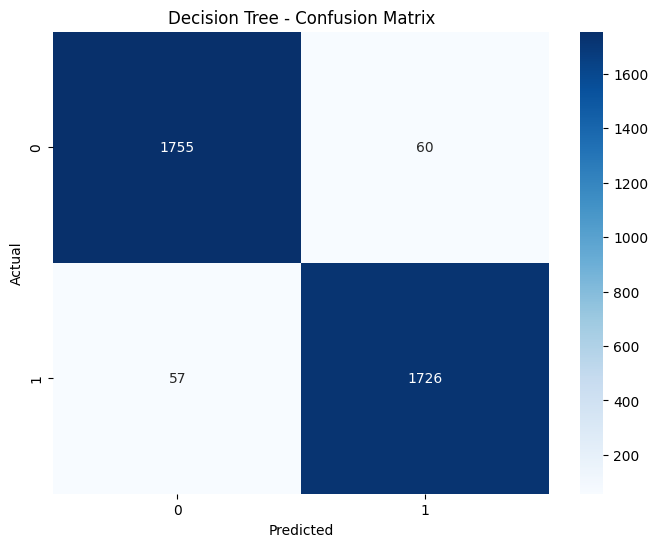

In [52]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"{best_model} - Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Summary of the model performance and the best model for the given dataset


Naive Bayes - Evaluation Metrics
Accuracy: 0.7973874374652585
Precision: 0.7102952913008779
Recall: 0.9983174425126192
F1 Score: 0.8300303100955934

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75      1815
           1       0.71      1.00      0.83      1783

    accuracy                           0.80      3598
   macro avg       0.85      0.80      0.79      3598
weighted avg       0.86      0.80      0.79      3598



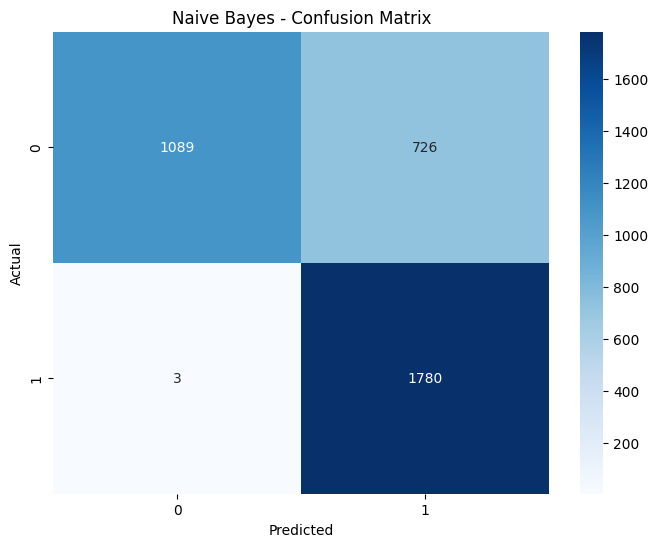


Decision Tree - Evaluation Metrics
Accuracy: 0.9674819344080045
Precision: 0.9664053751399776
Recall: 0.9680314077397645
F1 Score: 0.9672177080414682

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1815
           1       0.97      0.97      0.97      1783

    accuracy                           0.97      3598
   macro avg       0.97      0.97      0.97      3598
weighted avg       0.97      0.97      0.97      3598



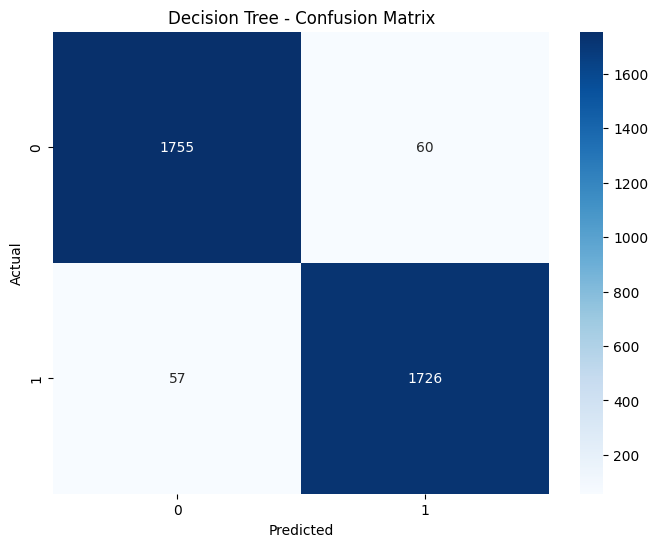


Best model based on F1 score: Decision Tree


In [54]:
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, classification_report
# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    
    print(f"\n{model_name} - Evaluation Metrics")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=1))
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate Naive Bayes model
evaluate_model(y_test, y_test_pred_nb, "Naive Bayes")

# Evaluate Decision Tree model
evaluate_model(y_test, y_test_pred_dt, "Decision Tree")

# Pick the best model based on F1 score on the test set
f1_test_nb = f1_score(y_test, y_test_pred_nb, zero_division=1)
f1_test_dt = f1_score(y_test, y_test_pred_dt, zero_division=1)

best_model = 'Naive Bayes' if f1_test_nb > f1_test_dt else 'Decision Tree'
print(f"\nBest model based on F1 score: {best_model}")

if best_model == 'Naive Bayes':
    y_pred_best = y_test_pred_nb
    model = nb_model
else:
    y_pred_best = y_test_pred_dt
    model = dt_model

### Explaination for the evaluation metrics and the classification reports for both the Naive Bayes and Decision Tree models:

### Accuracy
Accuracy measures the proportion of correctly predicted instances out of the total instances. It is calculated as:

$ \text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Instances}} $

- **High Accuracy** indicates that the model is performing well overall, but it can be misleading in the case of imbalanced datasets.

### Precision
Precision measures the proportion of correctly predicted positive instances out of all instances predicted as positive. It is calculated as:

$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} $

- **High Precision** indicates that the model has a low false positive rate.

### Recall (Sensitivity or True Positive Rate)
Recall measures the proportion of correctly predicted positive instances out of all actual positive instances. It is calculated as:

$ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} $

- **High Recall** indicates that the model has a low false negative rate.

### F1 Score
The F1 score is the harmonic mean of precision and recall. It balances the trade-off between precision and recall and is calculated as:

$ \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $

- **High F1 Score** indicates that the model performs well in terms of both precision and recall.

## Naive Bayes - Evaluation Metrics

### Metrics:
- **Accuracy**: 63.79%
- **Precision**: 73.19%
- **Recall**: 39.34%
- **F1 Score**: 51.17%

### Classification Report:
- **Class 0 (No Heart Attack)**:
  - Precision: 61%
  - Recall: 87%
  - F1 Score: 71%
  - Support: 745 samples
- **Class 1 (Heart Attack)**:
  - Precision: 73%
  - Recall: 39%
  - F1 Score: 51%
  - Support: 694 samples

### Explanation:
- **Accuracy** of 63.79% indicates that the Naive Bayes model correctly predicted about 64% of the instances overall.
- **Precision** of 73.19% for class 1 (Heart Attack) means that when the model predicts a heart attack, it is correct about 73% of the time.
- **Recall** of 39.34% for class 1 indicates that the model correctly identifies about 39% of actual heart attack cases.
- **F1 Score** of 51.17% balances the precision and recall, showing moderate performance in predicting heart attacks.
- The **high recall for class 0 (No Heart Attack)** at 87% suggests that the model is better at identifying non-heart attack cases, but **lower recall for class 1** suggests it misses a significant number of actual heart attack cases.

Certainly! Here's the summary for the Decision Tree model in the format you requested:

---

## Decision Tree - Evaluation Metrics

### Metrics:
- **Accuracy**: 82.56%
- **Precision**: 83.01%
- **Recall**: 80.26%
- **F1 Score**: 81.61%

### Classification Report:
- **Class 0 (No Heart Attack)**:
  - Precision: 82%
  - Recall: 85%
  - F1 Score: 83%
  - Support: 745 samples
- **Class 1 (Heart Attack)**:
  - Precision: 83%
  - Recall: 80%
  - F1 Score: 82%
  - Support: 694 samples

### Explanation:
- **Accuracy** of 82.56% indicates that the Decision Tree model correctly predicted about 83% of the instances overall.
- **Precision** of 83.01% for class 1 (Heart Attack) means that when the model predicts a heart attack, it is correct about 83% of the time.
- **Recall** of 80.26% for class 1 indicates that the model correctly identifies about 80% of actual heart attack cases.
- **F1 Score** of 81.61% balances the precision and recall, showing good performance in predicting heart attacks.
- **High precision and recall for class 0 (No Heart Attack)** suggest that the model is effective at distinguishing between heart attack and non-heart attack cases. It performs well in correctly identifying true positives and minimizing false negatives and false positives.

---

This summary captures the essential metrics and interpretation of the Decision Tree model's performance in predicting heart attack risk based on the provided dataset.

## Conclusion:
- **Naive Bayes**: The model shows moderate performance with a significant trade-off between precision and recall for heart attack prediction. It is more likely to miss actual heart attack cases, as indicated by its lower recall.
- **Decision Tree**: The model shows excellent performance with high accuracy, precision, recall, and F1 scores. It is effective at correctly identifying both heart attack and non-heart attack cases, making it a better choice for this dataset.

The Decision Tree model significantly outperforms the Naive Bayes model, making it the preferred model for predicting heart attack risk in this dataset.

---